# Scan analysis

In [1]:
%load_ext autoreload
%autoreload 2

# %matplotlib widget

In [51]:
import pandas as pd

from math import floor

import seaborn as sns

import numpy as np
# import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from xgboost import XGBRegressor
import shap


from plots2.fns import (
    get_corner_annotations,
)

from plots2.consts import (
    SMALL_FONT,
    MEDIUM_FONT,
    BIGGER_FONT,
)

from poly2.utils import (
    get_dispersal_kernel,
    trait_vec,
    beta_dist,
    gamma_dist,
    edge_values,
    get_dist_mean,
)
from poly2.run import no_joblib_single_run, no_joblib_multiple_run
from poly2.config import Config, ConfigMixture, get_asymptote_config
from poly2.simulator import SimulatorOneTrait, SimulatorAsymptote
from poly2.consts import FUNG_DECAY_RATE, MUTATION_PROP, MUTATION_SCALE

In [3]:
df = pd.read_csv('../outputs/combined/scan_all.csv')

In [4]:
df.head(2)

,run,year,best_dose,n_pos_diff,in_0p0_0p1,in_0p1_0p2,in_0p2_0p3,in_0p3_0p4,in_0p4_0p5,in_0p5_0p6,...,in_0p8_0p9,in_0p9_1p0,mu,b,asymptote,dec_rate_multiplier,m_prop_multiplier,m_scale_multiplier,ME_var,ME_mean
0,0,1,1.0,9,1.0,5.054079e-27,7.584700e-34,1.472094e-39,4.846678e-45,9.976588e-51,...,2.492945e-74,3.501367e-90,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,5.044122e-17,0.398241
1,0,2,1.0,9,1.0,5.054079e-27,7.584700e-34,1.472094e-39,4.846678e-45,9.976588e-51,...,2.492945e-74,3.501367e-90,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,5.044122e-17,0.398241


In [14]:
cf = Config(verbose=False)

default_b = cf.k_b
default_mu = cf.k_mu
a = cf.k_mu * cf.k_b
init_dist = gamma_dist(cf.n_k, a, cf.k_b)
tv = trait_vec(cf.n_k)
# NB get_dist_var/mean needs init_dist to be shape (n_k, n_years)
reshaped = init_dist.reshape((cf.n_k, 1))
default_ME_mean = get_dist_mean(reshaped, tv)[0]

## Plot

### Type 1

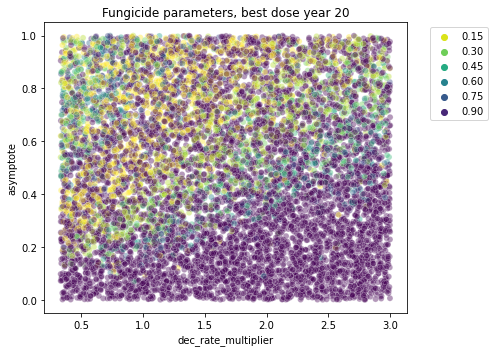

In [6]:
f, ax = plt.subplots(figsize=(7, 5))

dfu = df.loc[lambda x: x.year.isin([20])]

sns.scatterplot(
    x='dec_rate_multiplier',
    y='asymptote',
    hue='best_dose',
    # style='year',
    # size='year',
    data=dfu,
    # alpha=1,
    alpha=0.4,
    palette='viridis_r',
    sizes=(20, 80)
    # s=100,
)

ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

ax.set_title('Fungicide parameters, best dose year 20')
plt.tight_layout()

### Type 2

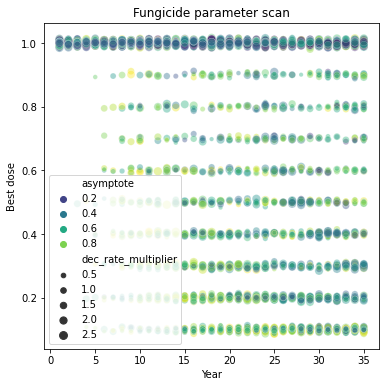

In [7]:
f, ax = plt.subplots(figsize=(6,6))


eps = 0.005
dft = df.head(10000).assign(best_dose_jitter = lambda x: x.best_dose + np.random.normal(0, eps, size=x.shape[0]))

sns.scatterplot(
    x='year',
    y='best_dose_jitter',
    
    # hue='dec_rate_multiplier',
    hue='asymptote',
    
    size='dec_rate_multiplier',
    
    data=dft,
    ax=ax,
    palette='viridis',
    alpha=0.4,
)

ax.set_xlabel('Year')
ax.set_ylabel('Best dose')

ax.set_title('Fungicide parameter scan')

ax.legend(loc='lower left')

# ax.set_xlim([0,50])

### Type 3

In [31]:
barchartdf = (
    df
    # .loc[lambda x: x.run.isin([0,1,2])]
    # .loc[lambda x: x.year<=30]
    .loc[:, ['best_dose', 'run', 'year']]
    
    # .assign(
    #     low = lambda x: x.best_dose<=0.1,
    #     midlow = lambda x: ((x.best_dose>0.1)
    #                         & (x.best_dose<=0.5)),
    #     midhigh = lambda x: ((x.best_dose>0.5)
    #                         & (x.best_dose<=0.9)),
    #     high = lambda x: x.best_dose>0.9,
    # )
    # .drop(['best_dose', 'run'], axis=1)
    
    .drop('run', axis=1)
    
    .groupby('year')
    
    # .sum()
    
    .value_counts()
    .reset_index()
    .rename(columns={0: 'count'})
    .pivot(index='year', columns='best_dose', values='count')
    
    # .assign(
    #     low = lambda x: x.low/10000,
    #     midlow = lambda x: x.midlow/10000,
    #     midhigh = lambda x: x.midhigh/10000,
    #     high = lambda x: x.high/10000,
    # )
)

barchartdf.head(5)

best_dose,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
year,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000.0
2,NaN,1.0,5.0,1.0,1.0,NaN,NaN,NaN,NaN,9992.0
3,11.0,12.0,10.0,4.0,4.0,5.0,1.0,2.0,3.0,9948.0
4,27.0,32.0,27.0,23.0,30.0,14.0,8.0,8.0,8.0,9823.0
5,53.0,72.0,74.0,56.0,29.0,37.0,21.0,19.0,23.0,9616.0


<AxesSubplot:xlabel='year'>

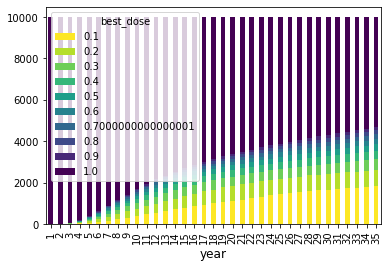

In [32]:
(
    barchartdf
    .plot
    .bar(
        stacked=True,
        colormap='viridis_r',
        legend=True
    )
)

### Line plot

In [121]:
pars = (
    df
    .loc[lambda x: x.run==3]
    .head(1)
    .filter(regex='^((?!in_0).)*$')
    .drop(['n_pos_diff', 'ME_var', 'best_dose', 'year', 'run'], axis=1)
    .rename(columns = {
        'dec_rate_multiplier': 'dec_rate',
        'm_prop_multiplier': 'm_prop',
        'm_scale_multiplier': 'm_scale',
        'asymptote': 'asymp',
    })
)

pars

,mu,b,asymp,dec_rate,m_prop,m_scale,ME_mean
105,21.750304,3.890784,0.978618,2.464423,0.83745,3.639639,0.023013


In [122]:
n_years = 35

cf = Config(
    n_years=n_years,
    n_k=300,
    verbose=False
)

cf.k_mu = pars.mu.values[0]
cf.k_b = pars.b.values[0]
cf.asymptote = pars.asymp.values[0]
cf.decay_rate = FUNG_DECAY_RATE * pars.dec_rate.values[0]
cf.mutation_proportion = MUTATION_PROP * pars.m_prop.values[0]
cf.mutation_scale_fung = MUTATION_SCALE * pars.m_scale.values[0]

In [123]:
%%time

line_df = pd.DataFrame()

for dose in tqdm(np.linspace(0.1, 1, 10)):

    cf.doses = dose*np.ones(cf.n_years)

    sim = SimulatorOneTrait(cf)

    data = sim.run_model()
    
    tmp = pd.DataFrame(
        dict(
            dose=np.repeat(dose, n_years),
            yld=data['yield_vec'],
            year=np.arange(1, 1+n_years),
        )
    )
    
    line_df = pd.concat([line_df, tmp])
    
line_df

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:13<00:00, 25.37s/it]

Wall time: 4min 13s


,dose,yld,year
0,0.1,9.239656,1
1,0.1,9.239644,2
2,0.1,9.239628,3
3,0.1,9.239607,4
4,0.1,9.239579,5
...,...,...,...
30,1.0,8.862599,31
31,1.0,8.858858,32
32,1.0,8.855498,33
33,1.0,8.852461,34


In [124]:
pivoted = line_df.pivot('year', 'dose', 'yld')

pivoted.head()

dose,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
year,,,,,,,,,,
1,9.239656,9.511557,9.691142,9.815843,9.906617,9.975260,10.028981,10.072208,10.107802,10.137678
2,9.239644,9.511536,9.691117,9.815815,9.906588,9.975231,10.028951,10.072179,10.107773,10.137650
3,9.239628,9.511504,9.691071,9.815759,9.906524,9.975161,10.028877,10.072102,10.107695,10.137572
4,9.239607,9.511453,9.690986,9.815641,9.906377,9.974989,10.028685,10.071893,10.107472,10.137337
5,9.239579,9.511370,9.690826,9.815392,9.906035,9.974555,10.028165,10.071294,10.106801,10.136602


In [125]:
line_df.head()

,dose,yld,year
0,0.1,9.239656,1
1,0.1,9.239644,2
2,0.1,9.239628,3
3,0.1,9.239607,4
4,0.1,9.239579,5


In [133]:
best_dose = (
    line_df
    .reset_index(drop=True)
    .groupby('year')
    .apply(lambda x: x.loc[x.yld.idxmax()])
    .assign(yy=10.3)
    .reset_index(drop=True)
    .loc[:, ['dose', 'year', 'yy']]
)

best_dose.head()

,dose,year,yy
0,1.0,1.0,10.3
1,1.0,2.0,10.3
2,1.0,3.0,10.3
3,1.0,4.0,10.3
4,1.0,5.0,10.3


In [140]:
eps = 0.2

bd_use = (
    pd.concat([
        best_dose.assign(year=lambda x: x.year - eps),
        best_dose.assign(year=lambda x: x.year + eps),
    ])
    .drop_duplicates()
    .sort_values('year')
)

## The plot

Interested in:

- mu
- ME_mean
- asympt
- dec_rate_multiplier
- m_prop_multiplier
- m_scale_multiplier

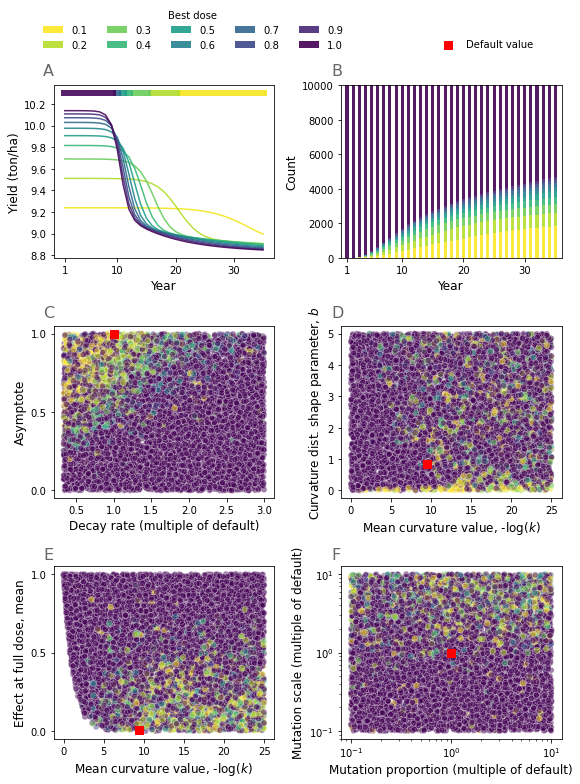

In [141]:
f, ax = plt.subplots(3, 2, figsize=(8, 12))

plt.rc('font', size=SMALL_FONT)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_FONT)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_FONT)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_FONT)  # fontsize of the figure title

# A
alpha_A = 0.9

COLZ = sns.color_palette('viridis_r', n_colors=60)

for ind, dose in enumerate(line_df.dose.unique()):
    n_d = len(line_df.dose.unique())
    
    col_ind = floor(ind*59/(-1+n_d))
    
    colr = COLZ[col_ind]
    
    ax[0][0].plot(line_df.loc[lambda x: x.dose==dose].year,
            line_df.loc[lambda x: x.dose==dose].yld,
            alpha=alpha_A,
            c=colr)
    
    ax[0][0].plot(bd_use.loc[lambda x: x.dose==dose].year,
            bd_use.loc[lambda x: x.dose==dose].yy,
            c=colr,
            alpha=alpha_A,
            lw=6)

# B
(
    barchartdf
    .plot
    .bar(
        stacked=True,
        colormap='viridis_r',
        alpha = 0.9,
        ax=ax[0][1],
        legend=True,
    )
)


# TYPE 2

dfu = df.loc[lambda x: x.year.isin([10])]

alpha = 0.5

# C
sns.scatterplot(
    x='dec_rate_multiplier',
    y='asymptote',
    hue='best_dose',
    data=dfu,
    alpha=alpha,
    palette='viridis_r',
    sizes=(20, 80),
    ax=ax[1][0],
    legend=False,
)

# D
sns.scatterplot(
    x='mu',
    y='b',
    hue='best_dose',
    data=dfu,
    alpha=alpha,
    palette='viridis_r',
    sizes=(20, 80),
    ax=ax[1][1],
    legend=False,
)

# E
sns.scatterplot(
    x='mu',
    y='ME_mean',
    hue='best_dose',
    data=dfu,
    alpha=alpha,
    palette='viridis_r',
    sizes=(20, 80),
    ax=ax[2][0],
    legend=False,
)

# F
sns.scatterplot(
    x='m_prop_multiplier',
    y='m_scale_multiplier',
    hue='best_dose',
    data=dfu,
    alpha=alpha,
    palette='viridis_r',
    sizes=(20, 80),
    ax=ax[2][1],
    legend=False,
)

cc = 'red'
marker = 's'
ss = 80






# layout


# A
ax[0][0].set_xlabel('Year')
ax[0][0].set_ylabel('Yield (ton/ha)')
# ax[0][1].set_xticks([0, 9, 19, 29])
ax[0][0].set_xticks([1,10,20,30])
ax[0][0].set_xticklabels([1,10,20,30], rotation=0)


# B
ax[0][1].set_xlabel('Year')
ax[0][1].set_ylabel('Count')

ax[0][1].set_ylim([0,10000])
ax[0][1].set_xlim([-1, 35])
ax[0][1].set_xticks([0, 9, 19, 29])
ax[0][1].set_xticklabels([1,10,20,30], rotation=0)

# C
ax[1][0].set_xlabel('Decay rate (multiple of default)')
ax[1][0].set_ylabel('Asymptote')

ax[1][0].set_yticks([0, 0.5, 1])
ax[1][0].scatter([1], [1], c=cc, s=ss, marker=marker, label='Default value')


# D
ax[1][1].set_xlabel(r'Mean curvature value, -log($k$)')
ax[1][1].set_ylabel(r'Curvature dist. shape parameter, $b$')

ax[1][1].scatter([default_mu], [default_b], c=cc, s=ss, marker=marker)



# E
ax[2][0].set_xlabel(r'Mean curvature value, -log($k$)')
ax[2][0].set_ylabel('Effect at full dose, mean')

ax[2][0].scatter([default_mu], [default_ME_mean], c=cc, s=ss, marker=marker)
ax[2][0].set_yticks([0, 0.5, 1])


# F
ax[2][1].set_xlabel('Mutation proportion (multiple of default)')
ax[2][1].set_ylabel('Mutation scale (multiple of default)')

ax[2][1].set_xscale('log')
ax[2][1].set_yscale('log')
ax[2][1].scatter([1], [1], c=cc, s=ss, marker=marker)



plt.tight_layout(rect=[0,0,1,0.83], h_pad=3)

ax[0][1].legend(
    bbox_to_anchor=(0.05, 1.15),
    loc='lower right',
    labels=[f'{ii:.1f}' for ii in np.arange(0.1,1.1,0.1)],
    title='Best dose',
    ncol=5,
    framealpha=0,
)

ax[1][0].legend(
    bbox_to_anchor=(1.7, 2.55),
    loc='lower left',
    framealpha=0,
)

get_corner_annotations(2, 3, 0.075, 0.82, 0.5, 0.28, plt)

NB this isn't a perfect representation but it's p good

In [146]:
f.savefig('../figures/paper/fig3.jpg', dpi=300, bbox_inches="tight")

<AxesSubplot:xlabel='year'>

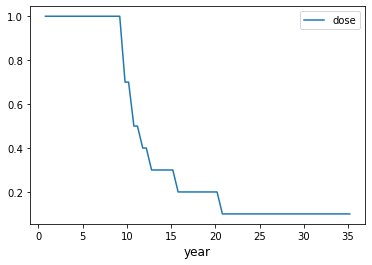

In [145]:
bd_use.plot(x='year', y='dose')